In [3]:
%load_ext cython

# Важно

Код написан на Python 3, потому что на втором питоне у меня возникли проблемы с импортом cython'овских библиотек из-за какой-то ошибки кодировки.

Выполнил Шевцов Антон

In [2]:
from line_profiler import LineProfiler

In [4]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

Улучшу реализацию своего алгоритма вычисления kmeans. Для проверки буду использовать учебный датасет из библиотеки sklearn.

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline

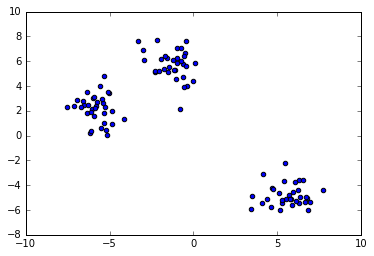

In [7]:
plt.scatter(X[:, 0], X[:, 1])

Как у меня было:

In [115]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import copy

def Kmeans(k ,max_iter , X, epsilon):
    centroids = X[np.random.choice(np.arange(len(X)),k)]

    for i in range(max_iter):
        centroids_old = copy.copy(centroids)

        # E-шаг
        labels = np.array(np.argmin(cdist(X, centroids), axis = 1))

        # M-шаг
        sum_dist = 0
        for l in range(k):
            centroids[l] = np.mean(X[labels == l], axis = 0) # пересчет центров
            sum_dist += euclidean(centroids_old[l], centroids[l]) # считаю расстояние от предыдущих центров


        # Проверка на сходимость
        if sum_dist < epsilon:
            return labels

    return labels

In [116]:
profile_print(Kmeans, 3,30,X,0.01)

Timer unit: 4.66533e-07 s

Total time: 0.00183534 s
File: <ipython-input-115-839d30cabc46>
Function: Kmeans at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def Kmeans(k ,max_iter , X, epsilon):
     7         1          209    209.0      5.3      centroids = X[np.random.choice(np.arange(len(X)),k)]
     8                                           
     9         2           10      5.0      0.3      for i in range(max_iter):
    10         2           68     34.0      1.7          centroids_old = copy.copy(centroids)
    11                                           
    12                                                   # E-шаг
    13         2          976    488.0     24.8          labels = np.array(np.argmin(cdist(X, centroids), axis = 1))
    14                                           
    15                                                   # M-шаг
    16         2            7      3.5      0.2        

Как видно из профайла в основном время просидает во время вычисления расстояния между старым и новым кластерами (19я строчка). Постараюсь добиться прироста в скорости за счет векторизации суммы в подсчете расстояний.

In [229]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import copy

def Kmeans(k ,max_iter , X, epsilon):
    centroids = X[np.random.choice(np.arange(len(X)),k)]

    for i in range(max_iter):
        centroids_old = copy.copy(centroids)

        # E-шаг
        labels = np.array(np.argmin(cdist(X, centroids), axis = 1))

        # M-шаг
        for l in range(k):
            centroids[l] = np.mean(X[labels == l], axis = 0) # пересчет центров

        # Считаю расстояние от настоящих центров до предыдущих
        sum_dist = np.dot(np.diagonal(np.array(cdist(centroids_old,centroids))), np.ones(k))

        # Проверка на сходимость
        if sum_dist < epsilon:
            return labels

    return labels

In [233]:
%%time
res = Kmeans(3,30,X,0.01)

Wall time: 974 µs


In [124]:
profile_print(Kmeans, 3,30,X,0.01)

Timer unit: 4.66533e-07 s

Total time: 0.00216331 s
File: <ipython-input-123-9a169f917928>
Function: Kmeans at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def Kmeans(k ,max_iter , X, epsilon):
     7         1          213    213.0      4.6      centroids = X[np.random.choice(np.arange(len(X)),k)]
     8                                           
     9         4           12      3.0      0.3      for i in range(max_iter):
    10         4          106     26.5      2.3          centroids_old = copy.copy(centroids)
    11                                           
    12                                                   # E-шаг
    13         4         1274    318.5     27.5          labels = np.array(np.argmin(cdist(X, centroids), axis = 1))
    14                                           
    15                                                   # M-шаг
    16        16           79      4.9      1.7        

In [263]:
%%time
res = Kmeans(3,30,X,0.01)

Wall time: 976 µs


Векторизация дала свой результат, теперь все вычисления происходят за сравнимое(похожее) время.

Как видно из профайла цикл в шаге M, который итерируется всего лишь по количеству классов работает сравнимо(примерно столько же) с векторизованными шагами E и подсчетом расстояний для проверки на сходимость. То есть работает оно примерно столько же как и векторизованное.

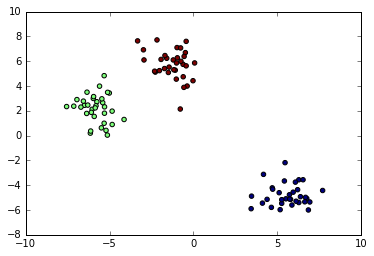

In [234]:
plt.scatter(X[:, 0], X[:, 1], c = res)

# Cython

Начнем преобразовывать этот код в cython код, начнем c преобразования типов.

Начнем преобразования с моего оригинальногокода, потому что векторизацию все равно придется раскрывать

In [23]:
%%cython -a
import numpy as np
cimport numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import copy

cpdef Kmeans(int k , int max_iter ,np.ndarray[np.float64_t, ndim=2] X,np.float64_t epsilon):
    
    cdef int n_objects, n_features, sum_dist;
    cdef np.ndarray[np.float64_t, ndim=2] centroids;
    cdef np.ndarray[np.float64_t, ndim=2] centroids_old;
    n_objects, n_features = X.shape[0], X.shape[1]
    
    
    #centroids = np.random.sample(X, k)
    centroids = X[np.random.choice(np.arange(len(X)),k)]

    for i in range(max_iter):

        centroids_old = copy.copy(centroids)

        # E-шаг
        labels = np.array(np.argmin(cdist(X, centroids), axis = 1))
        #print (labels)

        # M-шаг
        sum_dist = 0
        for l in range(k):
            centroids[l] = np.mean(X[labels == l], axis = 0) # пересчет центров
            sum_dist += euclidean(centroids_old[l], centroids[l]) # считаю расстояние от предыдущих центров

        # Проверка на сходимость
        if sum_dist < epsilon:
            return centroids

    return centroids

In [26]:
%%time
res = Kmeans(3,30,X,0.01)

Wall time: 1.98 ms


Время не очень впечатляет и весь код желтый, то есть плохо интерпритируется в СИ и не дает желаемого прироста в скорости.

Раскроем для начала E-шаг, то есть запишем его в виде СИ кода

In [27]:
%%cython -a
import numpy as np
cimport numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import euclidean
import copy
import cython

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef Kmeans(int k , int max_iter ,np.ndarray[np.float64_t, ndim=2] X,np.float64_t epsilon, random_state = 220):
    
    cdef int n_objects, n_features;
    cdef np.float64_t dist, sum_dist;
    cdef np.float64_t min_;
    cdef np.ndarray[np.float64_t, ndim=2] centroids;
    cdef np.ndarray[np.float64_t, ndim=2] centroids_old;
    n_objects, n_features = X.shape[0], X.shape[1]
    cdef np.ndarray[np.float64_t, ndim=1] labels;
    
    labels = np.zeros(n_objects)#, dtype = 'int')

    np.random.seed(random_state)
    centroids = X[np.random.choice(np.arange(len(X)),k)]
    
    for i in range(max_iter):

        centroids_old = copy.copy(centroids)

        # E-шаг
        # Вместо labels = np.array(np.argmin(cdist(X, centroids), axis = 1)) теперь
        for obj in range(n_objects): # для каждого x из X 
            min_= 0.
            for f in range(n_features):
                min_ += (X[obj,f] - centroids[0,f]) * (X[obj,f] - centroids[0,f])
            for i in range(1, k): # считаем расстояние до центра k-ого кластера
                dist = 0
                for f in range(n_features):
                    dist += (X[obj,f] - centroids[i,f]) * (X[obj,f] - centroids[i,f])
                if dist < min_:
                    min_ = dist
                    labels[obj] = i
        #print (labels)
        # M-шаг
        sum_dist = 0
        for l in range(k):
            centroids[l] = np.mean(X[labels == l], axis = 0) # пересчет центров
            sum_dist += euclidean(centroids_old[l], centroids[l]) # считаю расстояние от предыдущих центров
        print sum_dist
        # Проверка на сходимость
        if sum_dist < epsilon:
            return labels

    return labels

In [28]:
res = Kmeans(3,30,X,0.01, 220)
print (res)

2.5835190828565366
0.0
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Теперь перепишем методы из M шага и проверки на сходимость в виде кода на СИ. И в итоге получаем:

In [47]:
%%cython -a
import numpy as np
cimport numpy as np
import copy
import cython

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef Kmeans(int k , int max_iter ,np.ndarray[np.float64_t, ndim=2] X,np.float64_t epsilon, random_state = 220):
    
    cdef int n_objects, n_features;
    cdef np.float64_t dist, sum_dist;
    cdef np.float64_t min_;
    cdef np.ndarray[np.float64_t, ndim=2] centroids;
    cdef np.ndarray[np.float64_t, ndim=2] centroids_old;
    n_objects, n_features = X.shape[0], X.shape[1]
    cdef np.ndarray[np.float64_t, ndim=1] labels;
    cdef np.ndarray[np.float64_t, ndim=1] counts;
    cdef int ind ;
    cdef np.float64_t nu;
    
    labels = np.zeros(n_objects)
    #counts = np.zeros(k)
    np.random.seed(random_state)
    centroids = X[np.random.choice(np.arange(len(X)),k)]

    for i in range(max_iter):

        centroids_old = copy.copy(centroids)
        counts = np.zeros(k)

        # E-шаг
        # Вместо labels = np.array(np.argmin(cdist(X, centroids), axis = 1)) теперь
        for obj in range(n_objects): # для каждого x из X 
            min_= 0.
            for f in range(n_features):
                min_ += (X[obj,f] - centroids[0,f]) * (X[obj,f] - centroids[0,f])
            for i in range(1, k): # считаем расстояние до центра k-ого кластера
                dist = 0
                for f in range(n_features):
                    dist += (X[obj,f] - centroids[i,f]) * (X[obj,f] - centroids[i,f])
                if dist < min_:
                    min_ = dist
                    labels[obj] = i

        
        #Проверка на сходимость
        sum_dist = 0
        for l in range(k):
            for f in range(n_features):
                sum_dist += (centroids_old[l,f] - centroids[l,f]) * (centroids_old[l,f] - centroids[l,f])

        if sum_dist < epsilon:
            return labels
        
        # M-шаг
        # centroids = np.zeros((k,n_features))
        for obj in range(n_objects):
            for f in range(n_features):
                centroids[obj, f] = 0
                
        for obj in range(n_objects):
            ind = int(labels[obj])
            counts[ind] += 1
            nu = 1 / counts[ind]
            for f in range(n_features):
                centroids[ind,f] = (1 - nu) * centroids[ind,f] + nu * X[obj,f]
                
    return labels

Теперь вся желтизна связана только с инициализацией массивов

In [48]:
%%timeit
res = Kmeans(3,30,X,0.01, 220)

The slowest run took 63.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 57.1 µs per loop


Скорость улучшилась в несколько раз 

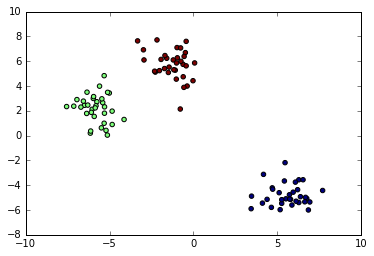

In [36]:
plt.scatter(X[:, 0], X[:, 1], c = res)

# Вывод: 

При использовании Python стоит пользоваться библиоткой NumPy которая за счет векторизации делает код более понятным и ускоряет время работы по сравнению со стандартными функциями Python. Однако при необходимости, переведя код в Cython можно добить еще более впечатляющих результатов.